In [96]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

(a) Implement the Expectation Maximisation algorithm for fitting a one-dimensional Gaussian mixture model to data points. Test your implementation with the Old Faithful Geyser Data set by considering only the duration of the eruption.

In [97]:
data = np.loadtxt("faithful.dat", skiprows=26, usecols=(1,)) # It is used the column 1. duration of the eruption
data

array([3.6  , 1.8  , 3.333, 2.283, 4.533, 2.883, 4.7  , 3.6  , 1.95 ,
       4.35 , 1.833, 3.917, 4.2  , 1.75 , 4.7  , 2.167, 1.75 , 4.8  ,
       1.6  , 4.25 , 1.8  , 1.75 , 3.45 , 3.067, 4.533, 3.6  , 1.967,
       4.083, 3.85 , 4.433, 4.3  , 4.467, 3.367, 4.033, 3.833, 2.017,
       1.867, 4.833, 1.833, 4.783, 4.35 , 1.883, 4.567, 1.75 , 4.533,
       3.317, 3.833, 2.1  , 4.633, 2.   , 4.8  , 4.716, 1.833, 4.833,
       1.733, 4.883, 3.717, 1.667, 4.567, 4.317, 2.233, 4.5  , 1.75 ,
       4.8  , 1.817, 4.4  , 4.167, 4.7  , 2.067, 4.7  , 4.033, 1.967,
       4.5  , 4.   , 1.983, 5.067, 2.017, 4.567, 3.883, 3.6  , 4.133,
       4.333, 4.1  , 2.633, 4.067, 4.933, 3.95 , 4.517, 2.167, 4.   ,
       2.2  , 4.333, 1.867, 4.817, 1.833, 4.3  , 4.667, 3.75 , 1.867,
       4.9  , 2.483, 4.367, 2.1  , 4.5  , 4.05 , 1.867, 4.7  , 1.783,
       4.85 , 3.683, 4.733, 2.3  , 4.9  , 4.417, 1.7  , 4.633, 2.317,
       4.6  , 1.817, 4.417, 2.617, 4.067, 4.25 , 1.967, 4.6  , 3.767,
       1.917, 4.5  ,

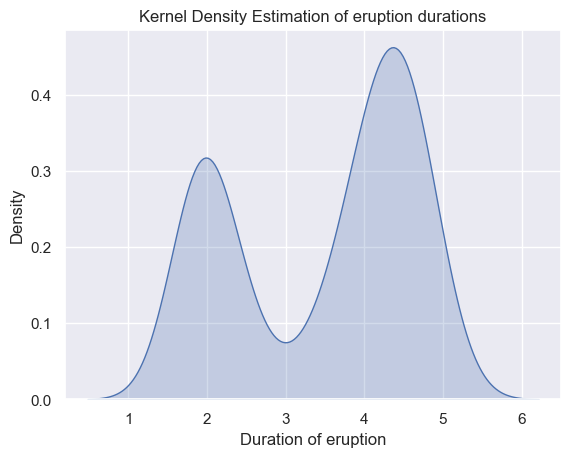

In [98]:
sns.kdeplot(data, fill=True)
plt.xlabel('Duration of eruption')
plt.ylabel('Density')
plt.title('Kernel Density Estimation of eruption durations')
plt.show()

$N(x;m,\sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}}exp^{-\frac{(x-m)^2}{2\sigma^2}}$

In [99]:
def gaussian_pdf(x, mu, sigma2):
    """ Gaussian probability density function """
    return (1.0 / np.sqrt(2 * np.pi * sigma2)) * np.exp(- (x - mu)**2 / (2 * sigma2))

The EM algorithm is an iterative algorithm that alternates between two steps:
1. E-step: calculate the expected value of the log-likelihood function, treating the latent variables as random variables.
2. M-step: maximize the expected value found on the E-step with respect to the model parameters.
3. Repeat until convergence.
4. The EM algorithm is guaranteed to converge to a local maximum of the likelihood function.

In [100]:
def em_gmm_1d(data, pi=0.5, n_iterations=100, tol=1e-5):
    # tol provides a mechanism to stop early if the estimates are no longer changing appreciably.
    """ Fit a GMM with 2 Gaussians to 1D data using the EM algorithm """
    N = len(data)

    mu_min = np.min(data)
    mu_max = np.max(data)
    sigma_min = 0.1
    sigma_max = 1.0

    mu = np.array([np.random.uniform(mu_min, mu_max), np.random.uniform(mu_min, mu_max)])
    sigma2 = np.array([np.random.uniform(sigma_min, sigma_max), np.random.uniform(sigma_min, sigma_max)])

    prev_log_likelihood = float('-inf')

    for iteration in range(n_iterations):
        # E-step: calculate responsibilities
        w1 = pi * gaussian_pdf(data, mu[0], sigma2[0])
        w2 = (1.0 - pi) * gaussian_pdf(data, mu[1], sigma2[1])

        # normalize weights
        W = w1 + w2
        w1 /= W
        w2 /= W

        # M-step: update parameters
        mu[0] = np.sum(w1 * data) / np.sum(w1)
        mu[1] = np.sum(w2 * data) / np.sum(w2)
        sigma2[0] = np.sum(w1 * (data - mu[0])**2) / np.sum(w1)
        sigma2[1] = np.sum(w2 * (data - mu[1])**2) / np.sum(w2)
        pi = np.mean(w1)

        # compute log-likelihood and check for convergence
        log_likelihood = np.sum(np.log(W))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return mu, sigma2, pi

def em_gmm_1d_best(data, n_iterations=20, n_random_restarts=500, tol=1e-4):
    best_mu = None
    best_sigma2 = None
    best_pi = None
    best_loglike = float('-inf')

    for _ in range(n_random_restarts):
        mu, sigma2, pi = em_gmm_1d(data, n_iterations=n_iterations, tol=tol)
        w1 = pi * gaussian_pdf(data, mu[0], sigma2[0])
        w2 = (1.0 - pi) * gaussian_pdf(data, mu[1], sigma2[1])
        log_likelihood = np.sum(np.log(w1 + w2))

        if log_likelihood > best_loglike:
            best_loglike = log_likelihood
            best_mu = mu
            best_sigma2 = sigma2
            best_pi = pi

    return best_mu, best_sigma2, best_pi

In [101]:
# Visualization function
def plot_gmm(data, mu, sigma2, pi, title):
    x = np.linspace(min(data), max(data), 1000)
    plt.hist(data, bins=30, density=True, alpha=0.6, color='b')
    plt.plot(x, pi * gaussian_pdf(x, mu[0], sigma2[0]), color='blue')
    plt.plot(x, (1-pi) * gaussian_pdf(x, mu[1], sigma2[1]), color='orange')
    plt.title(title)
    plt.show()

In [102]:
# Fit GMM with EM algorithm without providing initial parameters
best_mu, best_sigma2, best_pi = em_gmm_1d_best(data)
print("Best mu = ", best_mu)
print("Best sigma2 = ", best_sigma2)
print("Best pi = ", best_pi)

Best mu =  [2.01856309 4.27330091]
Best sigma2 =  [0.05548402 0.19108009]
Best pi =  0.34838543782232834


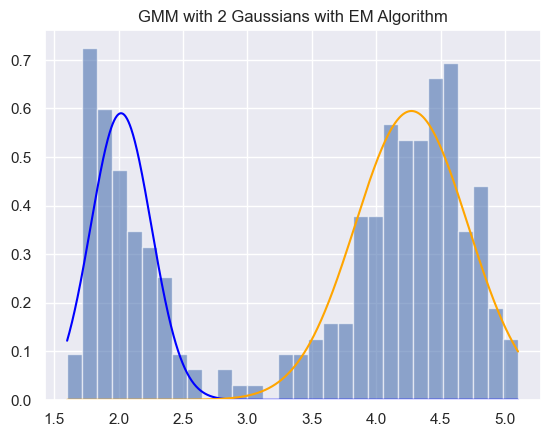

In [103]:
plot_gmm(data, best_mu, best_sigma2, best_pi, f"GMM with 2 Gaussians with EM Algorithm")

(b) Try the fitting with different initialisations and visualise the estimation results. Show both an example when the algorithm converges to a good solution and when it fails. Can you explain why it fails sometimes?

#### Good initialization
In this case, the means are initialized with the 25th percentile (first quartile) and the 75th percentile (third quartile) of the data. By choosing the quartiles, the initialization is using the data's distribution to make an educated guess about where the Gaussians might be. This is expected to be a "good" initialization because it's based on the data distribution itself.

In [104]:
def em_gmm_1d_det(data, mu, sigma2, pi, n_iterations=200, tol=1e-4):
    # tol provides a mechanism to stop early if the estimates are no longer changing appreciably.
    """ Fit a GMM with 2 Gaussians to 1D data using the EM algorithm """
    N = len(data)

    for iteration in range(n_iterations):
        # E-step: calculate responsibilities
        w1 = pi * gaussian_pdf(data, mu[0], sigma2[0])
        w2 = (1.0 - pi) * gaussian_pdf(data, mu[1], sigma2[1])

        # normalize weights
        W = w1 + w2
        w1 /= W
        w2 /= W

        # M-step: update parameters
        mu[0] = np.sum(w1 * data) / np.sum(w1)
        mu[1] = np.sum(w2 * data) / np.sum(w2)
        sigma2[0] = np.sum(w1 * (data - mu[0])**2) / np.sum(w1)
        sigma2[1] = np.sum(w2 * (data - mu[1])**2) / np.sum(w2)
        pi = np.mean(w1)

        # compute log-likelihood and check for convergence
        log_likelihood = np.sum(np.log(W))
        if iteration > 0 and np.abs(log_likelihood - prev_log_likelihood) < tol:
            break
        prev_log_likelihood = log_likelihood

    return mu, sigma2, pi

In [105]:
# Good initialization
mu_good_init = np.array([np.percentile(data, 25), np.percentile(data, 75)])
sigma2_good_init = np.array([1.0, 1.0])
pi_good_init = 0.5

mu_good, sigma2_good, pi_good = em_gmm_1d_det(data, mu_good_init, sigma2_good_init, pi_good_init)
print("Good mu = ", mu_good)
print("Good sigma2 = ", sigma2_good)
print("Good pi = ", pi_good)

Good mu =  [2.01867431 4.27340657]
Good sigma2 =  [0.0555676  0.19094118]
Good pi =  0.3484331597477799


#### Bad initialization
The means of the two Gaussian distributions (mu_bad_init = [0, 0.01]) are very close to each other. This means that, initially, the two distributions will be almost indistinguishable from one another, which might cause difficulties in separating the data into two clusters.

In [107]:
# Bad initialization
mu_bad_init = np.array([0, 0.01])
sigma2_bad_init = np.array([2.0, 2.0])
pi_bad_init = 0.5

mu_bad, sigma2_bad, pi_bad = em_gmm_1d_det(data, mu_bad_init, sigma2_bad_init, pi_bad_init)
print("Bad mu = ", mu_bad)
print("Bad sigma2 = ", sigma2_bad)
print("Bad pi = ", pi_bad)

Bad mu =  [3.48387339 3.49162529]
Bad sigma2 =  [1.30009217 1.29579299]
Bad pi =  0.49564667909106924


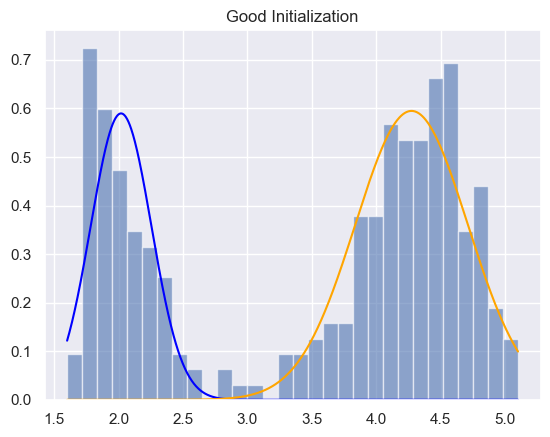

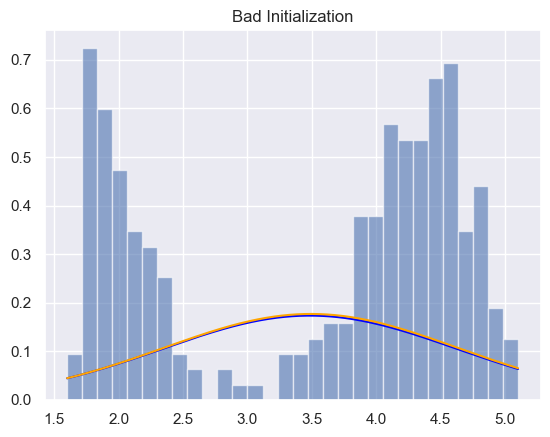

In [108]:
# Plotting
plot_gmm(data, mu_good, sigma2_good, pi_good, "Good Initialization")
plot_gmm(data, mu_bad, sigma2_bad, pi_bad, "Bad Initialization")

The EM algorithm, like many optimization algorithms, is sensitive to initialization. If the two Gaussians are initialized too close to each other, the algorithm might converge to a local maximum of the likelihood, effectively identifying only one cluster in the data. Since the EM algorithm only refines the initial guess, it can sometimes get stuck if that guess is too far from the truth. That's why using domain knowledge, data exploration, or multiple initializations followed by choosing the result with the highest likelihood is essential.